# Introduction

This notebook demonstrates hybrid cnn with one layer of quantum for binary classification problem using eurosat dataset.

# Runtime req

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q torch
!pip install -q matplotlib
!pip install -q visualkeras
!pip install -q qiskit
!pip install pylatexenc

!unzip -q "/content/drive/MyDrive/colab_notebooks/IITD-QML/EuroSAT_RGB.zip"

replace EuroSAT_RGB/Forest/Forest_864.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import qiskit
import sys
import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import random
import time

import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

from qiskit import *
provider = qiskit
backend = Aer.get_backend("aer_simulator", device="GPU")


## GPU and CPU detection choice

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataset handling for loading, splitting, training.

The following section has the utilities required for operating with the data.
- Detect list of classes from the dataset root directory provided ( inside the constructor )
- Load path labels, ( image paths and labels per class ) and shuffle the data set to generate randomness.
- Provide a generator which can be provided into the torch circuit with random data set selection insde the training or test data set.



In [ ]:
import glob
import os
import numpy as np
import random

class DatasetHandler:
    def __init__(self, ds_root_path):
        print ('Datahandler init -> ', ds_root_path)
        self.dataset_path = ds_root_path
        self.classes = glob.glob(os.path.join(ds_root_path, '*'))
        self.classes_dict = {}
        for c, i in zip(self.classes, range(len(self.classes))):
          self.classes_dict[c] = i

    def print_classes(self):
        print('Classes in the path: ')
        for i,c in enumerate(self.classes):
            print(i, ' ->', c)

    def load_paths_labels(self, root, classes):
        imgs_path = []
        imgs_label = []

        for clss in classes:
            for path in glob.glob(os.path.join(root, clss+'/*')):
              imgs_path.append(path)
              imgs_label.append(self.classes_dict[clss])

        dataset = list(zip(imgs_path, imgs_label))
        random.shuffle(dataset)
        paths, labels = zip(*dataset)
        return np.array(paths), np.array(labels)

    # Split the dataset into training and validation dataset
    def train_validation_split(self, images, labels, split_factor = 0.2):
        val_size = int(len(images)*split_factor)
        train_size = int(len(images) - val_size)
        return images[0:train_size], labels[0:train_size, ...], images[train_size:train_size+val_size], labels[train_size:train_size+val_size, ...]

    # Data genertor: given images paths and images labels yield a batch of images and labels
    def cnn_data_loader(self, imgs_path, imgs_label, batch_size = 1, img_shape = (64, 64, 3), n_classes = 2):
      # Initialize the vectors to be yield
      batch_in = np.zeros((batch_size, img_shape[2], img_shape[0], img_shape[1]))
      batch_out = np.zeros((batch_size))
      random.seed(time.time())

      dataset = list(zip(imgs_path, imgs_label))
      random.shuffle(dataset)
      imgs_path, imgs_label = zip(*dataset)

      from collections import defaultdict
      ra = defaultdict(bool)

      while True:
        for i in range(batch_size):
          index = 0
          while ra[index] == True:
            index = random.randint(0, len(imgs_path)-1)
          ra[index] = True
          batch_in[i, ...] = np.transpose(plt.imread(imgs_path[index])/255.0)
          batch_out[i] = imgs_label[index]
          yield  torch.tensor(batch_in).type(torch.float).to(device),  torch.tensor(batch_out).type(torch.float).to(device)



In [ ]:
sys.path.append('/content/drive/MyDrive/colab_notebooks/IITD-QML/')
dataset_root_path = '/content/EuroSAT_RGB'


In [ ]:
handler = DatasetHandler(dataset_root_path)
imgs_path, imgs_label = handler.load_paths_labels(dataset_root_path, handler.classes)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

Datahandler init ->  /content/EuroSAT_RGB
Dataset images: 27000 Dataset labels: 27000
Dataset sample -> /content/EuroSAT_RGB/Pasture/Pasture_499.jpg 2


In [ ]:
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)
print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape)

X_train shape: (21600,) Y_train shape: (21600,)
  X_val shape:  (5400,)   Y_val shape:  (5400,)


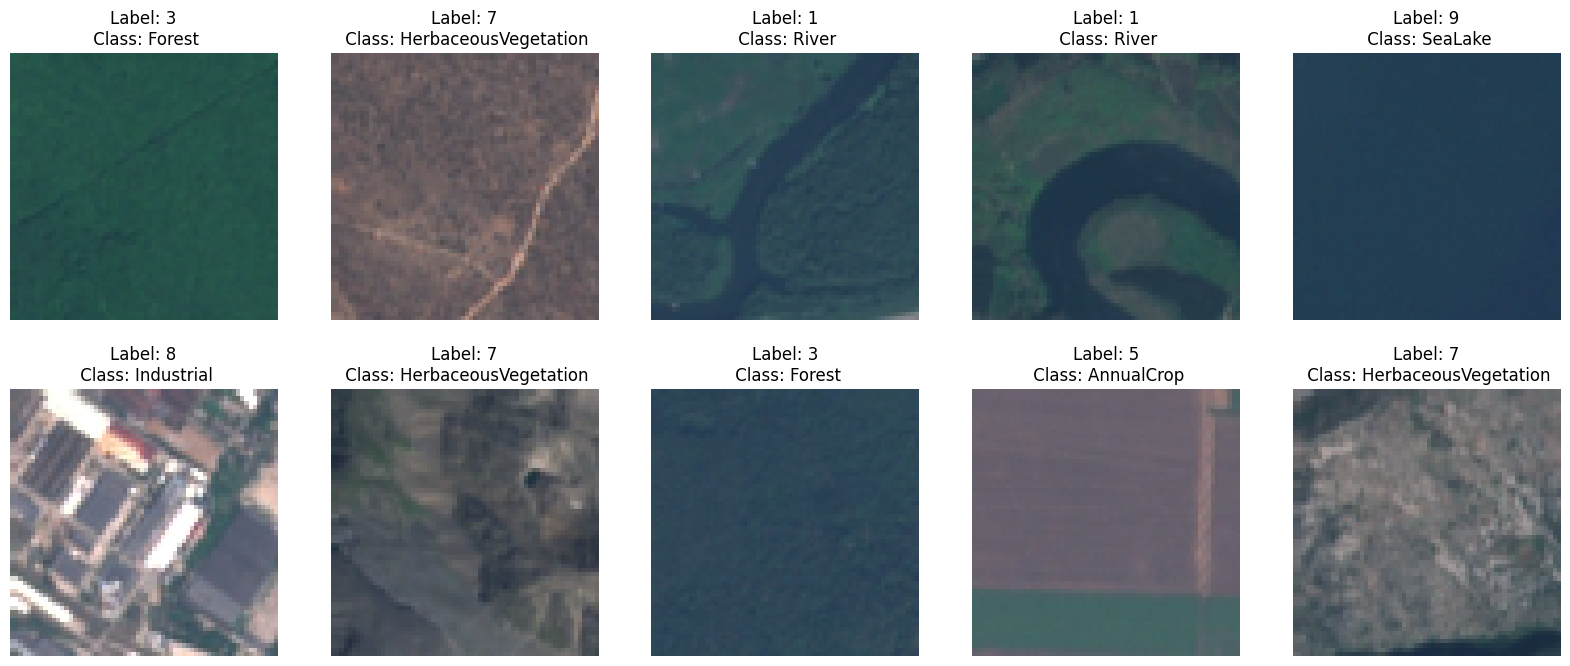

In [ ]:
def plotDataset(images, labels, classes, columns, rows):
    fig, axes = plt.subplots(nrows = rows, ncols = columns, figsize = (columns*4,rows*4))
    for x in range(columns):
        for y in range(rows):
            index = random.randint(0, len(images)-1)

            axes[y,x].imshow(plt.imread(images[index]))
            axes[y,x].set_title('Label: ' + str(labels[index]) +
                                '\n Class: ' + classes[labels[index]].split('/')[-1])
            axes[y,x].axis(False)

    plt.show()
plotDataset(train_imgs, train_labels, handler.classes, columns = 5, rows = 2)

# Classical multi-class classification CNN

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(2304, 16)
        self.fc2 = nn.Linear(16, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))

        x = x.view(-1, 2304)


        x = self.fc1(x)
        x = np.pi*torch.tanh(x)
        x = self.fc2(x.float())
        x = F.softmax(x, 1)

        return x

    def predict(self, x):
        # apply softmax
        pred = self.forward(x)
#         print(pred)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)

network = Net().to(device)
optimizer = optim.Adam(network.parameters(), lr=0.0002)

In [ ]:
from torchsummary import summary
summary(network, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
            Conv2d-2           [-1, 32, 29, 29]           4,640
            Conv2d-3           [-1, 64, 12, 12]          18,496
            Linear-4                   [-1, 16]          36,880
            Linear-5                   [-1, 10]             170
Total params: 60,634
Trainable params: 60,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.75
Params size (MB): 0.23
Estimated Total Size (MB): 1.02
----------------------------------------------------------------


In [ ]:
train_loss_list = []
val_loss_list = []
epochs = 40

loss_func = nn.CrossEntropyLoss()

for epoch in range(epochs):
  dataset = list(zip(train_imgs, train_labels))
  random.shuffle(dataset)
  train_imgs, train_labels = zip(*dataset)
  train_loader = iter(handler.cnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
  test_loader = iter(handler.cnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
  total_loss = []
  for batch_idx in range(len(train_labels)):
    data, target = next(train_loader)
    # print(batch_idx)
    optimizer.zero_grad()
    # Forward pass
    output = network(data)
    target = target.type(torch.LongTensor).to(device)
    # Calculating loss
    loss = loss_func(output, target)
    # Backward pass
    loss.backward()
    # Optimize the weights
    optimizer.step()

    total_loss.append(loss.item())

    print('\r Epoch %d ~ Batch %d (%d) ~ Loss %f ' % (epoch, batch_idx, len(train_imgs)-1, loss.item()), end='\t\t')


  with torch.no_grad():
    val_loss = []
    targets = []
    predictions = []
    for batch_idx in range(len(val_images)):
      data, target = next(test_loader)
      output = network(data)
      target = target.type(torch.LongTensor).to(device)

      loss = loss_func(output, target)
      val_loss.append(loss.item())

      targets.append(target.item())

      predictions.append(network.predict(data).item())


    train_loss_list.append(sum(total_loss)/len(total_loss))
    val_loss_list.append(sum(val_loss)/len(val_loss))

    print('Training [{:.0f}%]\t Training Loss: {:.4f} Validation Loss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, train_loss_list[-1], val_loss_list[-1]))

    print(confusion_matrix(targets, predictions,normalize='true'))
    print(classification_report(targets, predictions, target_names=[c.split('/')[-1] for c in handler.classes], digits=4))

    torch.save({
            'epoch': epoch,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss_list[-1],
            }, '/content/drive/MyDrive/colab_notebooks/IITD-QML/model-hybrid-multi-class-classical-bell.pt')


 Epoch 0 ~ Batch 21599 (21599) ~ Loss 1.464916 		Training [2%]	 Training Loss: 2.0399 Validation Loss: 1.9786
[[0.28542914 0.41117764 0.         0.00399202 0.21556886 0.04391218
  0.         0.0239521  0.01596806 0.        ]
 [0.08488613 0.81987578 0.         0.04968944 0.02070393 0.01449275
  0.         0.00621118 0.00414079 0.        ]
 [0.01975309 0.58024691 0.         0.31604938 0.00246914 0.
  0.         0.07901235 0.00246914 0.        ]
 [0.00327332 0.01963993 0.         0.97545008 0.         0.
  0.         0.00163666 0.         0.        ]
 [0.04952077 0.0942492  0.         0.         0.7827476  0.00159744
  0.         0.         0.07188498 0.        ]
 [0.07462687 0.17578773 0.         0.01824212 0.039801   0.51907131
  0.         0.16086235 0.01160862 0.        ]
 [0.0876494  0.1752988  0.         0.00398406 0.17729084 0.16533865
  0.         0.30876494 0.08167331 0.        ]
 [0.06540448 0.13425129 0.         0.07056799 0.18244406 0.03442341
  0.         0.48020654 0.0327022

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 Epoch 1 ~ Batch 21599 (21599) ~ Loss 1.461758 		Training [5%]	 Training Loss: 1.9539 Validation Loss: 2.0399
[[0.500998   0.14371257 0.01397206 0.         0.06187625 0.00998004
  0.         0.00199601 0.26746507 0.        ]
 [0.27329193 0.49482402 0.15320911 0.00207039 0.00828157 0.00207039
  0.         0.         0.06418219 0.00207039]
 [0.07654321 0.22469136 0.48641975 0.0345679  0.02716049 0.00740741
  0.         0.01234568 0.         0.1308642 ]
 [0.0212766  0.06219313 0.03436989 0.81505728 0.         0.00163666
  0.         0.         0.         0.06546645]
 [0.08626198 0.00479233 0.         0.         0.26996805 0.
  0.         0.         0.63897764 0.        ]
 [0.24378109 0.13598673 0.04477612 0.00165837 0.03150912 0.35489221
  0.         0.01492537 0.15588723 0.01658375]
 [0.33665339 0.03585657 0.00199203 0.         0.23705179 0.05976096
  0.         0.01593625 0.312749   0.        ]
 [0.17211704 0.07401033 0.00516351 0.00516351 0.30636833 0.00344234
  0.         0.22203098 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 Epoch 2 ~ Batch 21599 (21599) ~ Loss 2.405670 		Training [8%]	 Training Loss: 1.8779 Validation Loss: 1.8523
[[0.4491018  0.23752495 0.05189621 0.00998004 0.0259481  0.08982036
  0.08982036 0.03592814 0.00998004 0.        ]
 [0.08902692 0.52380952 0.17598344 0.07660455 0.         0.0931677
  0.         0.02277433 0.         0.01863354]
 [0.00246914 0.01975309 0.76790123 0.08395062 0.         0.02469136
  0.         0.0345679  0.         0.06666667]
 [0.         0.00818331 0.04255319 0.94435352 0.         0.
  0.         0.00163666 0.         0.00327332]
 [0.19808307 0.03674121 0.         0.         0.69329073 0.
  0.00319489 0.02236422 0.04632588 0.        ]
 [0.00165837 0.00165837 0.09286899 0.00497512 0.00165837 0.69320066
  0.16583748 0.02155887 0.         0.01658375]
 [0.10956175 0.05577689 0.06772908 0.00398406 0.01593625 0.21314741
  0.41832669 0.10756972 0.00796813 0.        ]
 [0.09982788 0.06540448 0.11015491 0.03614458 0.03270224 0.01204819
  0.11187608 0.51462995 0.0172117 

In [ ]:
torch.save(network.state_dict(), '/content/drive/MyDrive/colab_notebooks/IITD-QML/model-multi-class-classical-lenet5-modif.pt')

In [ ]:
test_loader = iter(handler.cnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
accuracy = 0
number = 0

predictions = []
targets = []

for ct in range(len(val_images)):
  data, target = next(test_loader)
  number +=1
  output = network.predict(data).item()

  predictions.append(output)
  targets.append(target.item())

  accuracy += (output == target[0].item())*1
  print('\r ' + str(ct), end='')

 5399

(array([501., 483., 405., 611., 626., 603., 502., 581., 489., 599.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

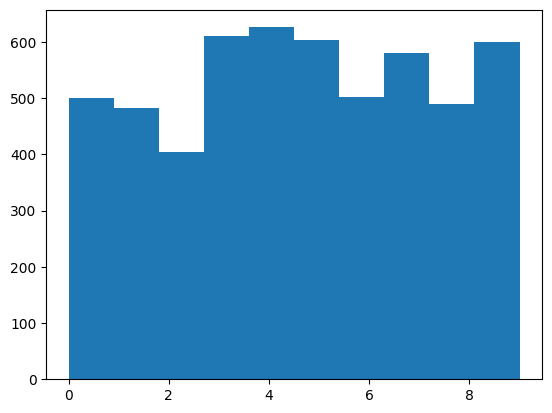

In [ ]:
plt.hist(targets, bins = 10)

In [ ]:
print("Performance on test data is : {}/{} = {}%".format(accuracy,number,100*accuracy/number))

Performance on test data is : 4348/5400 = 80.51851851851852%


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(targets, predictions,normalize='true')

S2
Accuracy: [0.81237525 0.77018634 0.67160494 0.8690671  0.7428115  0.85074627
 0.4561753  0.89156627 0.95092025 0.96160267] mean:  0.7977055876922472
                      precision    recall  f1-score   support

             Highway     0.7903    0.8124    0.8012       501
               River     0.7470    0.7702    0.7584       483
             Pasture     0.8527    0.6716    0.7514       405
              Forest     0.9725    0.8691    0.9179       611
         Residential     0.9831    0.7428    0.8462       626
          AnnualCrop     0.8369    0.8507    0.8438       603
       PermanentCrop     0.7293    0.4562    0.5613       502
HerbaceousVegetation     0.5717    0.8916    0.6967       581
          Industrial     0.7922    0.9509    0.8643       489
             SeaLake     0.9157    0.9616    0.9381       599

            accuracy                         0.8052      5400
           macro avg     0.8191    0.7977    0.7979      5400
        weighted avg     0.8242    0.805

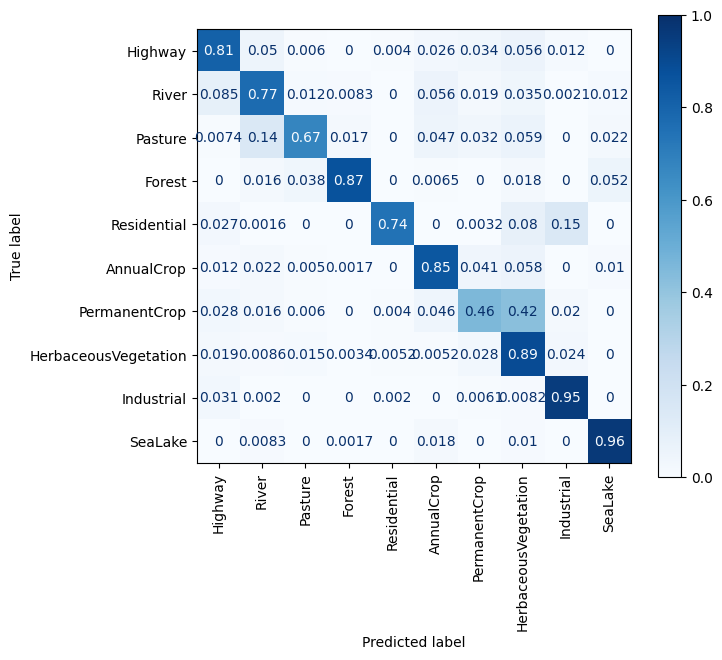

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (7,6))
cnames = target_names=[c.split('/')[-1] for c in handler.classes]
cmd = ConfusionMatrixDisplay(cm, display_labels=cnames)
cmd.plot(ax=axes, cmap='Blues', xticks_rotation='vertical')
print('S2')
print('Accuracy:', cm.diagonal(), 'mean: ', cm.diagonal().mean())
print(classification_report(targets, predictions, target_names=cnames, digits=4))
axes.get_images()[0].set_clim(0, 1)
plt.show()
plt.close()